## 试试检验钻头尺寸（所有井的基础井径）


In [7]:
"""
检验钻头尺寸 - 自动识别所有井的基础井径
目标：
1. 读取所有井的 LAS 文件
2. 筛选 H1-1 到 H2-1 层位之间的数据
3. 计算每口井井径曲线的众数（代表钻头尺寸）
"""

import os
from pathlib import Path

import lasio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# 设置中文字体支持
plt.rcParams["font.sans-serif"] = ["SimHei", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

# ============ 1. 准备数据路径 ============
las_dir = Path("..") / "data" / "vertical_well_las"
horizon_file = Path("..") / "data" / "well_horizon.xlsx"

print("=" * 60)
print("钻头尺寸自动识别")
print("=" * 60)

# 读取层位数据
horizon_df = pd.read_excel(horizon_file, sheet_name="Sand Thickness")
print(f"\n✓ 成功读取层位文件: {horizon_file}")
print(f"  包含 {len(horizon_df['Well'].unique())} 口井的层位数据")

# 获取所有 LAS 文件
las_files = sorted(las_dir.glob("*.las"))
print(f"\n✓ 找到 {len(las_files)} 个 LAS 文件")
print(f"  文件列表: {[f.stem for f in las_files]}")
print("-" * 60)

钻头尺寸自动识别

✓ 成功读取层位文件: ..\data\well_horizon.xlsx
  包含 46 口井的层位数据

✓ 找到 7 个 LAS 文件
  文件列表: ['PH1', 'PH13', 'PH2', 'PH3', 'PH4', 'PH5', 'PH6']
------------------------------------------------------------


In [8]:
# ============ 2. 定义井径曲线的可能名称 ============
# 不同的 LAS 文件可能使用不同的助记符
CALI_MNEMONICS = ["CAL", "CALI", "CALIPER", "BS", "BIT"]


def find_caliper_curve(las_obj):
    """在 LAS 对象中查找井径曲线"""
    for mnemonic in CALI_MNEMONICS:
        if mnemonic in las_obj.keys():
            return mnemonic
    return None


# ============ 3. 处理每口井 ============
results = []

for las_file in las_files:
    well_name = las_file.stem
    print(f"\n处理井: {well_name}")
    print("-" * 40)

    try:
        # 读取 LAS 文件
        las = lasio.read(las_file)
        print(f"  ✓ 读取成功，深度范围: {las.index[0]:.2f} - {las.index[-1]:.2f} m")

        # 查找井径曲线
        cali_name = find_caliper_curve(las)
        if cali_name is None:
            print(f"  ⚠ 警告: 未找到井径曲线，跳过")
            continue

        print(f"  ✓ 找到井径曲线: {cali_name}")

        # 获取该井的层位信息
        well_horizons = horizon_df[horizon_df["Well"] == well_name].copy()

        if len(well_horizons) == 0:
            print(f"  ⚠ 警告: 未找到层位数据，跳过")
            continue

        # 找到 H1-1 和 H2-1 的深度
        h1_1 = well_horizons[well_horizons["Surface"] == "H2-1"]
        h2_1 = well_horizons[well_horizons["Surface"] == "H3Ding(23D)"]

        if len(h1_1) == 0 or len(h2_1) == 0:
            print(f"  ⚠ 警告: 缺少 H1-1 或 H2-1 层位，跳过")
            continue

        depth_top = h1_1["MD"].values[0]
        depth_bottom = h2_1["MD"].values[0]

        print(f"  ✓ 目标层位深度: {depth_top:.2f} - {depth_bottom:.2f} m")

        # 筛选目标深度范围的井径数据
        depth = las.index
        cali_data = las[cali_name]

        mask = (depth >= depth_top) & (depth <= depth_bottom)
        cali_target = cali_data[mask]

        # 去除空值
        cali_valid = cali_target[~np.isnan(cali_target)]

        if len(cali_valid) == 0:
            print(f"  ⚠ 警告: 目标层位无有效井径数据，跳过")
            continue

        print(f"  ✓ 有效数据点数: {len(cali_valid)}")

        # ============ 4. 计算众数（钻头尺寸） ============
        # 方法1: 使用 scipy.stats.mode (推荐用于离散数据)
        mode_result = stats.mode(cali_valid, keepdims=True)
        bit_size_mode = mode_result.mode[0]

        # 方法2: 使用直方图的峰值 (更适合连续数据)
        # 将数据分成 0.1 英寸的小区间
        hist, bin_edges = np.histogram(cali_valid, bins=np.arange(cali_valid.min(), cali_valid.max() + 0.1, 0.1))
        bit_size_hist = bin_edges[np.argmax(hist)]

        # 其他统计信息
        cali_min = cali_valid.min()
        cali_max = cali_valid.max()
        cali_mean = cali_valid.mean()
        cali_median = np.median(cali_valid)

        print(f"  井径统计:")
        print(f"    最小值: {cali_min:.2f} in")
        print(f"    最大值: {cali_max:.2f} in")
        print(f"    平均值: {cali_mean:.2f} in")
        print(f"    中位数: {cali_median:.2f} in")
        print(f"    众数(离散): {bit_size_mode:.2f} in")
        print(f"    众数(直方图): {bit_size_hist:.2f} in")

        # 保存结果
        results.append(
            {
                "Well": well_name,
                "Caliper_Name": cali_name,
                "Depth_Top": depth_top,
                "Depth_Bottom": depth_bottom,
                "Data_Points": len(cali_valid),
                "Min": cali_min,
                "Max": cali_max,
                "Mean": cali_mean,
                "Median": cali_median,
                "Mode_Discrete": bit_size_mode,
                "Mode_Histogram": bit_size_hist,
                "Bit_Size": bit_size_hist,  # 推荐使用直方图法
            }
        )

    except Exception as e:
        print(f"  ❌ 处理失败: {type(e).__name__}: {str(e)}")
        continue

print("\n" + "=" * 60)
print("处理完成")
print("=" * 60)


处理井: PH1
----------------------------------------
  ✓ 读取成功，深度范围: 0.00 - 5155.00 m
  ✓ 找到井径曲线: CAL
  ✓ 目标层位深度: 2289.50 - 2376.00 m
  ✓ 有效数据点数: 866
  井径统计:
    最小值: 12.19 in
    最大值: 14.35 in
    平均值: 12.87 in
    中位数: 12.59 in
    众数(离散): 12.27 in
    众数(直方图): 12.49 in

处理井: PH13
----------------------------------------
  ✓ 读取成功，深度范围: 0.00 - 5525.00 m
  ✓ 找到井径曲线: CAL
  ⚠ 警告: 缺少 H1-1 或 H2-1 层位，跳过

处理井: PH2
----------------------------------------
  ✓ 读取成功，深度范围: 0.00 - 4600.00 m
  ✓ 找到井径曲线: CAL
  ⚠ 警告: 缺少 H1-1 或 H2-1 层位，跳过

处理井: PH3
----------------------------------------
  ✓ 读取成功，深度范围: 0.00 - 4245.00 m
  ✓ 找到井径曲线: CAL
  ✓ 目标层位深度: 2369.33 - 2449.50 m
  ✓ 有效数据点数: 802
  井径统计:
    最小值: 11.23 in
    最大值: 26.62 in
    平均值: 12.27 in
    中位数: 12.16 in
    众数(离散): 12.11 in
    众数(直方图): 12.13 in

处理井: PH4
----------------------------------------
  ✓ 读取成功，深度范围: 0.00 - 4295.00 m
  ✓ 找到井径曲线: CAL
  ✓ 目标层位深度: 2268.51 - 2351.22 m
  ✓ 有效数据点数: 827
  井径统计:
    最小值: 12.13 in
    最大值: 15.48 in
    平均值: 12.


✓ 井径直方图已保存到: output\caliper_histograms.png


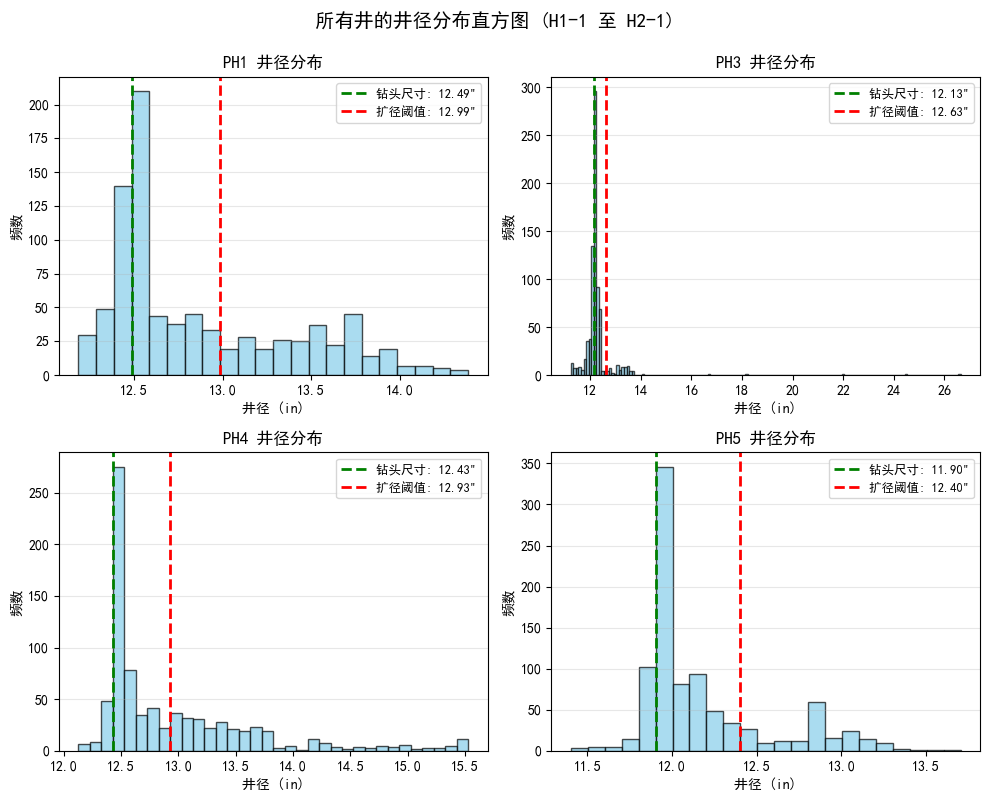

In [9]:
# ============ 5. 绘制井径直方图 ============
if len(results) > 0:
    n_wells = len(results)

    # 计算子图布局（尽量接近正方形）
    n_cols = int(np.ceil(np.sqrt(n_wells)))
    n_rows = int(np.ceil(n_wells / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

    # 如果只有一口井，确保 axes 是列表
    if n_wells == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, result in enumerate(results):
        ax = axes[idx]

        # 重新读取该井的数据用于绘图
        las_file = las_dir / f"{result['Well']}.las"
        las = lasio.read(las_file)

        depth = las.index
        cali_data = las[result["Caliper_Name"]]

        # 筛选目标深度
        mask = (depth >= result["Depth_Top"]) & (depth <= result["Depth_Bottom"])
        cali_target = cali_data[mask]

        # 去除空值
        cali_valid = cali_target[~np.isnan(cali_target)]

        # 绘制直方图（使用 0.1 英寸的小区间）
        bins = np.arange(cali_valid.min(), cali_valid.max() + 0.1, 0.1)
        counts, bin_edges, patches = ax.hist(cali_valid, bins=bins, color="skyblue", edgecolor="black", alpha=0.7)

        # 标注钻头尺寸（众数）
        bit_size = result["Bit_Size"]
        ax.axvline(x=bit_size, color="green", linestyle="--", linewidth=2, label=f'钻头尺寸: {bit_size:.2f}"')

        # 标注扩径阈值
        threshold = bit_size + 0.5
        ax.axvline(x=threshold, color="red", linestyle="--", linewidth=2, label=f'扩径阈值: {threshold:.2f}"')

        # 设置标题和标签
        ax.set_title(f"{result['Well']} 井径分布", fontsize=12, fontweight="bold")
        ax.set_xlabel("井径 (in)", fontsize=10)
        ax.set_ylabel("频数", fontsize=10)
        ax.legend(loc="best", fontsize=9)
        ax.grid(True, alpha=0.3, axis="y")

        # # 在图上标注统计信息
        # stats_text = (f"样本数: {result['Data_Points']}\n"
        #              f"平均值: {result['Mean']:.2f}\"\n"
        #              f"中位数: {result['Median']:.2f}\"\n"
        #              f"范围: {result['Min']:.2f}\"-{result['Max']:.2f}\"")
        # ax.text(0.98, 0.97, stats_text, transform=ax.transAxes,
        #         fontsize=8, verticalalignment='top', horizontalalignment='right',
        #         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 隐藏多余的子图
    for idx in range(n_wells, len(axes)):
        axes[idx].set_visible(False)

    plt.suptitle("所有井的井径分布直方图 (H1-1 至 H2-1)", fontsize=14, fontweight="bold", y=0.995)
    plt.tight_layout()

    # 保存图像
    output_dir = Path("output")
    output_dir.mkdir(exist_ok=True)
    output_file = output_dir / "caliper_histograms.png"
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    print(f"\n✓ 井径直方图已保存到: {output_file}")

    plt.show()
else:
    print("\n❌ 没有可用的结果来绘制直方图")